In [1]:
import re 
import nltk
import numpy as np, pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (16,8)

## Talk Lengths

In [3]:
df_male = pd.read_csv('talks_male.csv', index_col='Talk_ID')
df_female = pd.read_csv('talks_female.csv', index_col='Talk_ID')

In [4]:
talks_male = df_male.text.tolist()
talks_female = df_female.text.tolist()

In [5]:
print(len(talks_male), len(talks_female))

714 260


In [6]:
def re_count (text):
    regex = [word for word in re.sub("[^a-zA-Z']"," ", text).lower().split()]
    return len(regex)

In [7]:
lengths_male = [re_count(text) for text in talks_male]
lengths_female = [re_count(text) for text in talks_female]

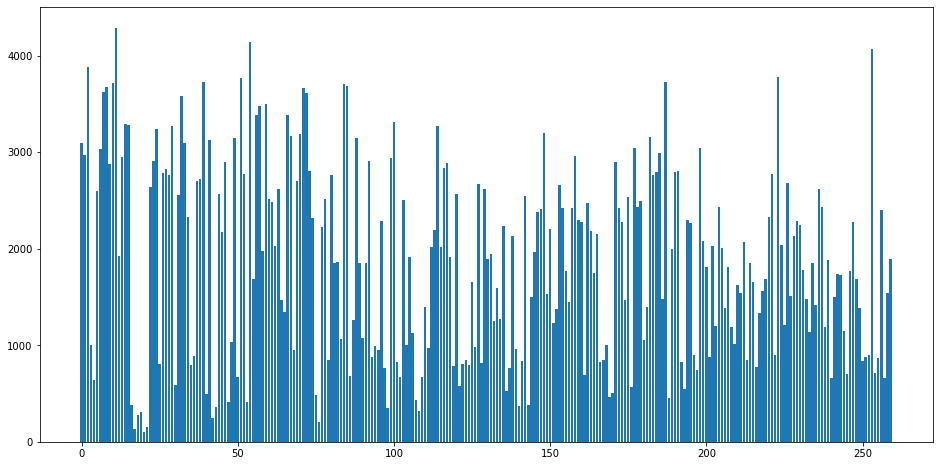

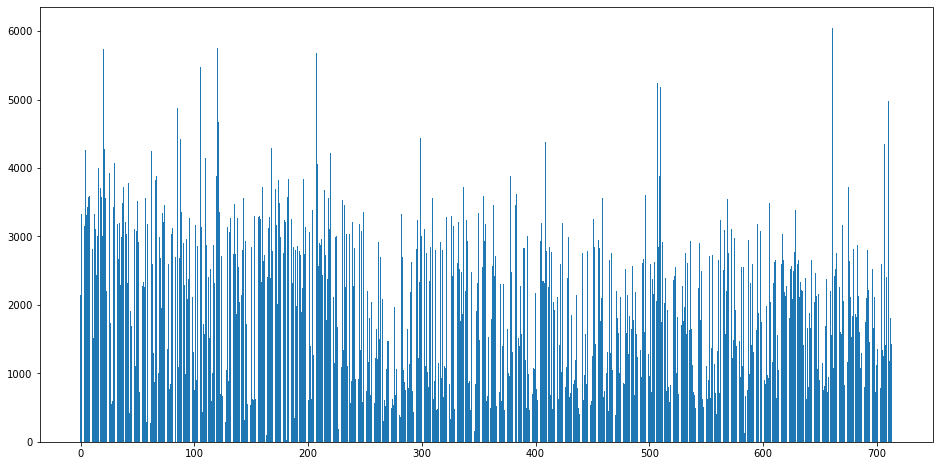

In [8]:
plt.bar(range(0,len(lengths_female)), lengths_female)
plt.show()
plt.bar(range(0,len(lengths_male)), lengths_male)
plt.show()

In [9]:
pretest_f = []
for text in talks_female:
    if re_count(text) > 3000:
        pretest_f.append(text)

pretest_m = [text for text in talks_male if re_count(text) > 3000]

print(len(pretest_f), len(pretest_m))

38 153


Of the 714 talks by men, 153 are over 3000 words (21%), and of the 260 talks by women, 38 are (15%). 

If we run separate vectorizers on the two sets of talks, each returns over 4400 features (terms) without `min_df = 2` being passed as a parameter. With it, the code and the results were as follows:

```
vectorizer_x = CountVectorizer( lowercase = True, min_df = 2 )
x = vectorizer_x.fit_transform(test_f)
vectorizer_y = CountVectorizer( lowercase = True, min_df = 2 )
y = vectorizer_y.fit_transform(test_m)

print(x.shape, y.shape)
(10, 1495) (10, 1492)
```

This code is being left out of the running version of the notebook because it isn't needed.

Instead, we combine the two lists of talks, 10 by men and 10 by women and each over 3000 words, into one list and then run that corpus through a single vectorizer, z.

In [10]:
test = pretest_f[0:10] + pretest_m[0:10]

vectorizer = CountVectorizer( lowercase = True, min_df = 2 )
z = vectorizer.fit_transform(test)
z.shape

(20, 2624)

## Densities

We are going to turn these results into a pandas dataframe so that we can do sum the word totals, then each term by the total, then average those densities so that we can compare term densities between men and women speakers.

<AxesSubplot:>

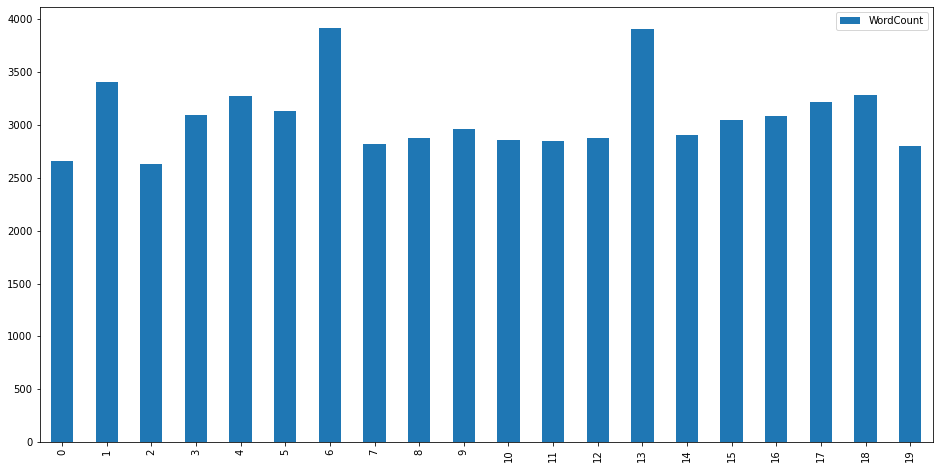

In [11]:
# Convert vectorizer results to array then to dataframe
df_all = pd.DataFrame(z.toarray(), columns = vectorizer.get_feature_names_out())

# Add column 
df_all['WordCount']= df_all.sum(axis=1)

# Quick visualization to make sure the numbers are what we think
df_all.plot(y="WordCount", kind="bar", figsize=(16, 8))

In [12]:
# Split the dataframe back into male and female
df_f = df_all.head(10)
df_m = df_all.tail(10)

In [13]:
# Divide all the columns by the WordCount column
df_fdensity = df_f.apply(lambda x: x.div(df_f.WordCount))
df_mdensity = df_m.apply(lambda x: x.div(df_m.WordCount))

In [14]:
# Add a row with the average of all the values in the column
df_fdensity.loc['FMD'] = df_fdensity.mean()
df_mdensity.loc['MMD'] = df_mdensity.mean()

Putting the two rows of densities into a single dataframe can be accomplished a little less *densely* by breaking the steps into the following lines:

```python
fd = df_fdensity.tail(1)
md = df_mdensity.tail(1)

data = [fd, md]

densities = pd.concat(data)
```

Which is more pythonic?

In [15]:
densities = pd.concat([df_fdensity.tail(1), df_mdensity.tail(1)])
densities.head()

,000,10,100,11,11th,12,13,14,15,150,...,york,you,young,your,yourself,youth,zero,zone,zoning,WordCount
FMD,0.000523,0.000610,0.000270,0.000144,0.000057,0.000242,0.000061,0.000065,0.000166,0.000026,...,0.000457,0.016769,0.000441,0.002026,0.000031,0.000026,0.000000,0.000000,0.000075,1.0
MMD,0.000615,0.000544,0.000498,0.000240,0.000000,0.000221,0.000096,0.000061,0.000129,0.000061,...,0.000213,0.025732,0.000123,0.004192,0.000163,0.000031,0.000088,0.000099,0.000034,1.0


We've got two rows which are the average densities of terms for 10 texts by women and 10 by men. Now let's see what the ratios look like:

In [16]:
densities.loc['F_to_M'] = densities.loc['FMD'] / densities.loc['MMD']
densities.loc['M_to_F'] = densities.loc['MMD'] / densities.loc['FMD']
densities.head()

,000,10,100,11,11th,12,13,14,15,150,...,york,you,young,your,yourself,youth,zero,zone,zoning,WordCount
FMD,0.000523,0.000610,0.000270,0.000144,0.000057,0.000242,0.000061,0.000065,0.000166,0.000026,...,0.000457,0.016769,0.000441,0.002026,0.000031,0.000026,0.000000,0.000000,0.000075,1.0
MMD,0.000615,0.000544,0.000498,0.000240,0.000000,0.000221,0.000096,0.000061,0.000129,0.000061,...,0.000213,0.025732,0.000123,0.004192,0.000163,0.000031,0.000088,0.000099,0.000034,1.0
F_to_M,0.851692,1.120459,0.543113,0.601775,inf,1.093823,0.636767,1.050263,1.290340,0.419133,...,2.147615,0.651698,3.585055,0.483329,0.187237,0.821429,0.000000,0.000000,2.183459,1.0
M_to_F,1.174134,0.892492,1.841238,1.661751,0.000000,0.914225,1.570433,0.952142,0.774990,2.385879,...,0.465633,1.534453,0.278936,2.068985,5.340816,1.217391,inf,inf,0.457989,1.0


In [17]:
df = densities.T
df.tail(10)

,FMD,MMD,F_to_M,M_to_F
york,0.000457,0.000213,2.147615,0.465633
you,0.016769,0.025732,0.651698,1.534453
young,0.000441,0.000123,3.585055,0.278936
your,0.002026,0.004192,0.483329,2.068985
yourself,0.000031,0.000163,0.187237,5.340816
youth,0.000026,0.000031,0.821429,1.217391
zero,0.000000,0.000088,0.000000,inf
zone,0.000000,0.000099,0.000000,inf
zoning,0.000075,0.000034,2.183459,0.457989
WordCount,1.000000,1.000000,1.000000,1.000000


In [18]:
df.sort_values('F_to_M', ascending=False).head(20)

,FMD,MMD,F_to_M,M_to_F
preferred,0.000058,0.0,inf,0.0
despair,0.000133,0.0,inf,0.0
destroying,0.000160,0.0,inf,0.0
destruction,0.000070,0.0,inf,0.0
regular,0.000063,0.0,inf,0.0
regard,0.000068,0.0,inf,0.0
developments,0.000138,0.0,inf,0.0
red,0.000174,0.0,inf,0.0
record,0.000177,0.0,inf,0.0
recognize,0.000058,0.0,inf,0.0


In [19]:
df.sort_values('M_to_F', ascending=False).head(20)

,FMD,MMD,F_to_M,M_to_F
rule,0.0,0.000132,0.0,inf
educate,0.0,0.000167,0.0,inf
seriously,0.0,0.000065,0.0,inf
currently,0.0,0.000067,0.0,inf
crowd,0.0,0.000100,0.0,inf
shaped,0.0,0.000168,0.0,inf
creativity,0.0,0.000208,0.0,inf
creative,0.0,0.000254,0.0,inf
sheep,0.0,0.000388,0.0,inf
shut,0.0,0.000070,0.0,inf
